In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
# sns.set_style('whitegrid')
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)


In [2]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [3]:
def load_pkl(pkl_path, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]
        
#         import ipdb
#         ipdb.set_trace()
        
        if "encode_time" not in data.keys():
            return
    
#     print(data['y_true'])
    
    
    y_true = np.concatenate(data["y_true"]) 
    
#     import ipdb
#     ipdb.set_trace()
    
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])
    
    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
#         metric = recall_score(y_pred=y_pred, y_true=y_true)
        metric = roc_auc_score(y_score=eta, y_true=y_true)
#         metric = f1_score(y_pred=y_pred, y_true=y_true)
#     print(data.keys())

#     import pdb
#     pdb.set_trace()
    if return_sizes:
        return metric, data["encode_time"], data["train_time"], data["test_time"], eta, data["train_size"], data["test_size"]
    else:
        return metric, data["encode_time"], data["train_time"], data["test_time"], eta

# DUD-E results

In [4]:
def plot_dude_results(dataset, split):
    
#     print(data_p)
    f, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
    ax = ax.flatten()
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"{dataset}*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []
#         import pdb
#         pdb.set_trace()
        
        
        for path in data_path_list:
            
#             print(path)
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
#             print(split_file)
            split_df = pd.read_csv(split_file)
            
            train_size = split_df[split_df["subset"] == "train"].shape[0]
            
            test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            
            m, encode_time, train_time, test_time, eta = load_pkl(path, return_sizes=False)
    #         import ipdb
    #         ipdb.set_trace()
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            
#         import pdb
#         pdb.set_trace()
        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], color=color, label=model)
    #     print(encode_time_list)

        sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)

    ax[0].axhline(y=0.5, color='k', linestyle='--', zorder=0)
    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("train set size")

    ax[1].set_ylabel("encode-time (s)")
    ax[1].set_yscale("log")
    ax[1].set_xlabel("train set size")

    ax[2].set_ylabel("train-time-per-epoch (s)")
    ax[2].set_xlabel("train set size")

    ax[3].set_ylabel("test-time (s)")
    ax[3].set_xlabel("train set size")

    plt.legend()
    return f, ax

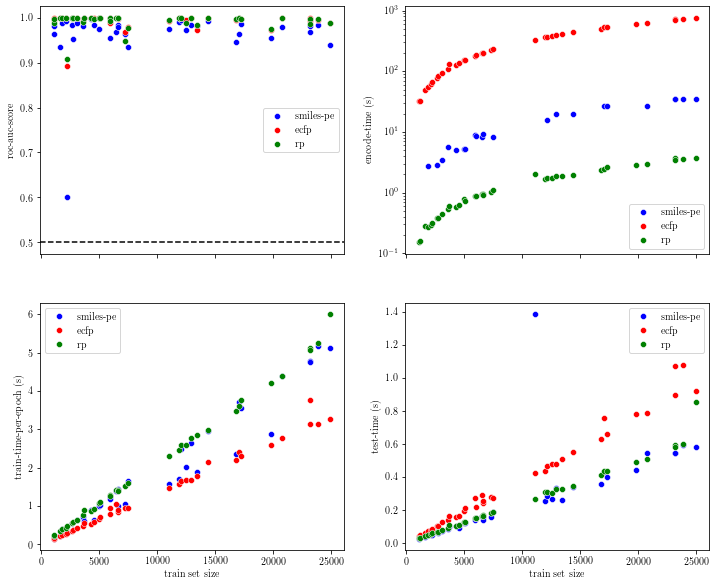

In [5]:
plot_dude_results(dataset="dude", split="random")
plt.savefig('dude-results-all.png', dpi=600)

# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [6]:
def plot_lit_pcba_results(split):
    
    f, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
    ax = ax.flatten()
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:
#     for model, color in [("ecfp", "blue")]:

        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"lit_pcba_*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []

        
        
        for path in data_path_list:
            
            target = path.stem.split("_")[2]
#             split = path.stem.split(".")[0].split("_")[-1]
#             split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
#             split_df = pd.read_csv(split_file)
            
#             train_size = split_df[split_df["subset"] == "train"].shape[0]
            
#             test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            
            m, encode_time, train_time, test_time, eta, train_size, test_size = load_pkl(path, return_sizes=True)
#             print(path, train_size)

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            

        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)


#         sns.scatterplot(x=list(range(len(metric_list))), y=metric_list, ax=ax[0], color=color, label=model)
#         sns.scatterplot(x=list(range(len(encode_time_list))), y=encode_time_list, ax=ax[1], color=color, label=model)
#         sns.scatterplot(x=list(range(len(train_time_list))), y=train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=list(range(len(test_time_list))), y=test_time_list, ax=ax[3], color=color, label=model)


    ax[0].axhline(y=0.5, color='k', linestyle='--', zorder=0)
    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("train set size")
#     ax[0].set_xscale("log")

    ax[1].set_ylabel("encode-time (s)")
    ax[1].set_yscale("log")
    ax[1].set_xlabel("train set size")

    ax[2].set_ylabel("train-time-per-epoch (s)")
    ax[2].set_xlabel("train set size")

    ax[3].set_ylabel("test-time (s)")
    ax[3].set_xlabel("train set size")

    plt.legend()
    return f, ax

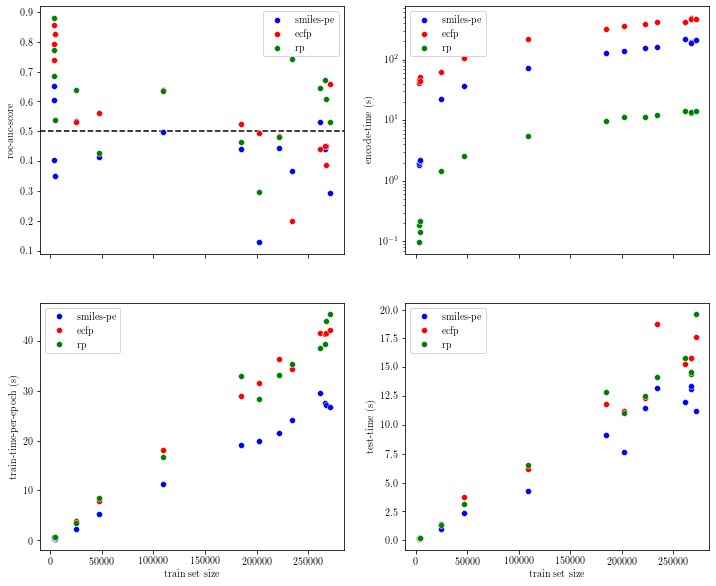

In [7]:
plot_lit_pcba_results(split="random_strat_split")
plt.savefig('lit-pcba-results-all.png', dpi=600)

# BBBP Benchmark

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(y_pred, y_true, ax):
#     f, ax = plt.subplots(1,1, figsize=(10,6))

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
    disp.plot(cmap="Purples", ax=ax)

In [9]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

def plot_roc_curve(y_score, y_true, ax, name):
    
    fpr, tpr, thresholds = roc_curve(y_score=y_score, y_true=y_true)
    roc_auc = auc(fpr, tpr)


    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot(ax=ax, name=name)

In [10]:
def plot_dist_plot(y_score, y_true, ax):
    
    neg_dist = y_score[y_true == 0]
    pos_dist = y_score[y_true == 1]
    
    
    sns.distplot(neg_dist, color="blue", ax=ax)
    sns.distplot(pos_dist, color="red", ax=ax)
    

In [11]:
def bbbp_main():
    
    
    path_list = ["/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.smiles-pe.pkl",
                "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.ecfp.pkl",
                "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.rp.pkl"]
    
    
    roc_f, roc_ax = plt.subplots(1,1, figsize=(10,6))

    
    for path in path_list:
        with open(path, "rb") as handle:
            data = pickle.load(handle)

            name = path.split('.')[-2]
            
            
            y_pred = data[0]['y_pred']
            y_true = data[0]['y_true']
            y_score = data[0]['eta']
            
            
            
            
#             confus_f, confus_ax = plt.subplots(1,1, figsize=(10,6))
#             plot_confusion_matrix(y_pred=y_pred, y_true=y_true, ax=confus_ax)
#             confus_f.suptitle(name)
            
            plot_roc_curve(y_score=y_score, y_true=y_true, ax=roc_ax, name=name)
            
#             dist_f, dist_ax = plt.subplots(1,1, figsize=(10,6))
#             plot_dist_plot(y_score=y_score, y_true=y_true, ax=dist_ax)
#             dist_f.suptitle(name)
            
            
    roc_ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    
    roc_f.suptitle("Blood-Brain-Barrier Permeability Reciever Operating Curve")
    plt.savefig("bbbp_result_roc.png", dpi=600, bbox_inches="tight")


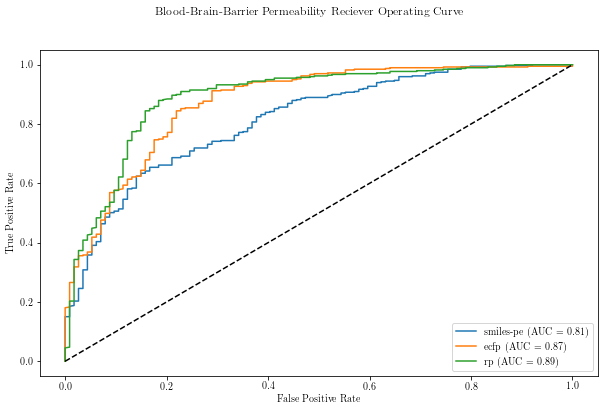

In [12]:
bbbp_main()

In [18]:
def plot_lit_pcba_results(split):
    
    f, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
    ax = ax.flatten()
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:
#     for model, color in [("ecfp", "blue")]:

        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"lit_pcba_*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []

        
        
        for path in data_path_list:
            
            target = path.stem.split("_")[2]
#             split = path.stem.split(".")[0].split("_")[-1]
#             split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
#             split_df = pd.read_csv(split_file)
            
#             train_size = split_df[split_df["subset"] == "train"].shape[0]
            
#             test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            
            m, encode_time, train_time, test_time, eta, train_size, test_size = load_pkl(path, return_sizes=True)
            print(path, train_size)

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            

        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)


#         sns.scatterplot(x=list(range(len(metric_list))), y=metric_list, ax=ax[0], color=color, label=model)
#         sns.scatterplot(x=list(range(len(encode_time_list))), y=encode_time_list, ax=ax[1], color=color, label=model)
#         sns.scatterplot(x=list(range(len(train_time_list))), y=train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=list(range(len(test_time_list))), y=test_time_list, ax=ax[3], color=color, label=model)


#     ax[0].axhline(y=0.5, color='k', linestyle='--')
#     ax[0].set_ylabel("roc-auc-score")
#     ax[0].set_xlabel("train set size")
# #     ax[0].set_xscale("log")

#     ax[1].set_ylabel("encode-time (s)")
#     ax[1].set_yscale("log")
#     ax[1].set_xlabel("train set size")

#     ax[2].set_ylabel("train-time-per-epoch (s)")
#     ax[2].set_xlabel("train set size")

#     ax[3].set_ylabel("test-time (s)")
#     ax[3].set_xlabel("train set size")

#     plt.legend()
#     return f, ax




def sider_main():
    
    
    model_dict = {"model": [], "task": [], "roc-auc": []}
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:

        data_path_list = list(data_p.glob(f"sider_*.{model}.pkl"))
        
        
#         print(data_path_list)
        
        

        for path in data_path_list:
            with open(path, "rb") as handle:
                
                
                data = pickle.load(handle)

                name = str(path).split('.')[-2]
                task = int(str(path).split('.')[0][-1])
            
                y_pred = data[0]['y_pred']
                y_true = data[0]['y_true']
                y_score = data[0]['eta']
        
                fpr, tpr, thresholds = roc_curve(y_score=y_score, y_true=y_true)
                roc_auc = auc(fpr, tpr)
                
                model_dict["model"].append(model)
                model_dict["task"].append(task)
                model_dict["roc-auc"].append(roc_auc)

    
    df = pd.DataFrame(model_dict)
    g = sns.catplot(data=df, x="model", y="roc-auc", kind="box", palette="deep", height=6, aspect=1.25)

    
    g.fig.suptitle("SIDER ROC-AUC Distribution Over Tasks")
    plt.savefig("sider_result_roc.png", dpi=600, bbox_inches="tight")


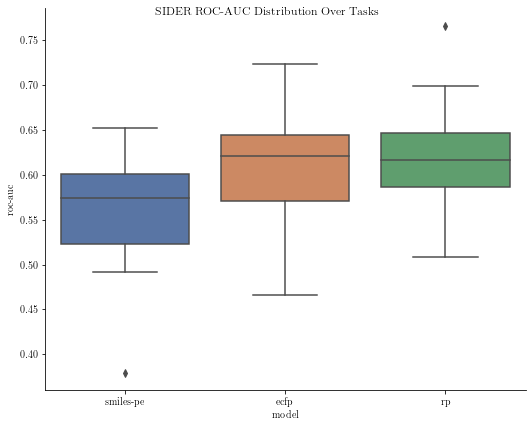

In [19]:
sider_main()